<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Musterlösung / Sample solution 
## 6th exercise: <font color="#C70039">Domain Adaption with Autoencoders</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   29.06.2022

---------------------------------

### Description 
This is one implementation example to demo the image reconstruction using autoencoders for domain adaption.
Please do not miss to try different optimizers and losses.

---------------------------------

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2022-11-20 13:38:18.561557: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-20 13:38:26.858444: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 13:38:26.861418: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-20 13:38:26.865491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-20 13:38:26.972973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import os
from   tqdm import tqdm
import time

### Load images:
**Gernot**

In [3]:
SIZE=256

In [4]:
# import input img
input_img_data=[]
input_path = './data/heisenberg_heisenberg/gernot/'
files=os.listdir(input_path)

# read all images in the folder (different rotations and flips of the original)
for i in tqdm(files):
    img=cv2.imread(input_path+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    input_img_data.append(img_to_array(grayImage))

100%|██████████| 50/50 [00:00<00:00, 97.92it/s]


In [5]:
input_img_data[0].shape

(256, 256, 1)

In [6]:
# import output_img
output_img_data=[]
output_path = './data/heisenberg_heisenberg/walter/'
files=os.listdir(output_path)

# read all images in the folder (same rotations and flips as img)
for i in tqdm(files):
    img=cv2.imread(output_path+'/'+i,1)  #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    output_img_data.append(img_to_array(grayImage))

100%|██████████| 50/50 [00:00<00:00, 106.03it/s]


In [7]:
output_img_data[0].shape

(256, 256, 1)

In [8]:
input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 1))
input_img_array = input_img_array.astype('float32') / 255. # normalize

output_img_array= np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 1))
output_img_array = output_img_array.astype('float32') / 255. # normalize

In [9]:
# Original image for prediction of output_img
# this one does not belong to the training set
test_img_data=[]

test_img=cv2.imread('./data/heisenberg_heisenberg/gernot-heisenberg-original.jpg', 1)   #Change 0 to 1 for color images
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)#Changing BGR to RGB to show images in true colors
test_img=cv2.resize(test_img,(SIZE, SIZE))
grayImage = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
test_img_data.append(img_to_array(grayImage))

test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 1))
test_img_array = test_img_array.astype('float32') / 255. # normalize

In [10]:
test_img_array.shape

(1, 256, 256, 1)

## Build the autoencoder-decoder model

In [11]:
# set the start time
# later needed for calculating the computation time
start=time.time()

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
     
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

# callbacks = [tf.keras.callbacks.TensorBoard(log_dir='einstein_logs')]

# fit the model of input_img to output_img
epochs = 500
model.fit(input_img_array, output_img_array, epochs=epochs, shuffle=True)#, callbacks=callbacks)

# print out the computation time
finish=time.time()
print('total computation time = ', finish-start)

# save the model
model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".model")

2022-11-20 13:38:37.703860: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-20 13:38:37.704893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 13:38:37.706190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA T500 computeCapability: 7.5
coreClock: 1.695GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 74.52GiB/s
2022-11-20 13:38:37.706378: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-20 13:38:37.706547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-20 13:38:37.706639: I tensorflow/stream_executor/platform/default/dso_

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         5

2022-11-20 13:38:38.704542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-20 13:38:38.706916: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2803200000 Hz


Epoch 1/500


2022-11-20 13:38:42.062097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-20 13:38:49.075527: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-20 13:38:51.093509: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1/2 [==============>...............] - ETA: 16s - loss: 0.1570 - accuracy: 1.2398e-05

2022-11-20 13:38:56.101093: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


2/2 [==============================] - 20s 4s/step - loss: 0.1555 - accuracy: 9.4223e-06
Epoch 2/500
2/2 [==============================] - 1s 393ms/step - loss: 0.1350 - accuracy: 3.6240e-07
Epoch 3/500
2/2 [==============================] - 1s 396ms/step - loss: 0.1084 - accuracy: 2.0345e-07
Epoch 4/500
2/2 [==============================] - 1s 393ms/step - loss: 0.0905 - accuracy: 2.0345e-07
Epoch 5/500
2/2 [==============================] - 1s 390ms/step - loss: 0.0880 - accuracy: 7.6930e-07
Epoch 6/500
2/2 [==============================] - 1s 397ms/step - loss: 0.0806 - accuracy: 4.7302e-06
Epoch 7/500
2/2 [==============================] - 1s 395ms/step - loss: 0.0767 - accuracy: 7.2479e-07
Epoch 8/500
2/2 [==============================] - 1s 393ms/step - loss: 0.0780 - accuracy: 0.0000e+00
Epoch 9/500
2/2 [==============================] - 1s 400ms/step - loss: 0.0784 - accuracy: 0.0000e+00
Epoch 10/500
2/2 [==============================] - 1s 395ms/step - loss: 0.0768 - accu

2022-11-20 13:48:04.152019: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: domain_adapt_autoenc_epochs.500.model/assets


Input image


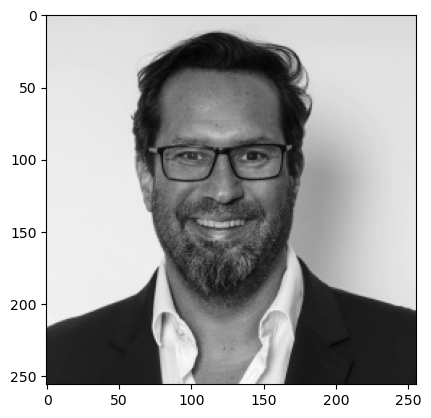

In [12]:
print("Input image")
plt.imshow(test_img_array.reshape(SIZE,SIZE),cmap='gray')
plt.show()

output of test image


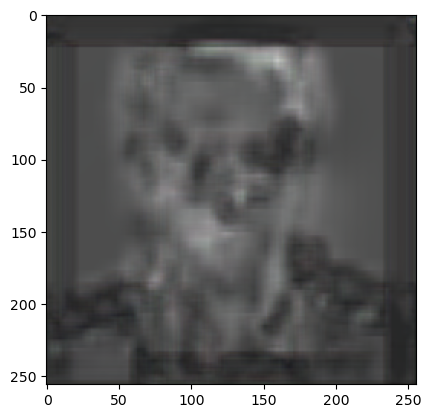

In [13]:
# predict the original image as test image, 
# since it did not belong to the training data.
# if the domain was really adapted, then the result would look like output_img

print("output of test image")
pred = model.predict(test_img_array)
plt.imshow(pred[0])
plt.show()

In [14]:
# save the model
model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".model")

INFO:tensorflow:Assets written to: domain_adapt_autoenc_epochs.500.model/assets
